You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Machine_Learning-USU/blob/fall22/Lectures/Class22-ML_application_stock_valuation/RF_classification_APPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 



## 🔗 Links
[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=red)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)
[![Profile](https://img.shields.io/badge/profiole-000?style=for-the-badge&logo=ko-fi&logoColor=white)](https://huntsman.usu.edu/directory/jahangiry-pedram)
[![linkedin](https://img.shields.io/badge/linkedin-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

---

# Random Forest in Time series:

There are couple of issues with time series that we need to be aware of: 
 
1. TS data is not iid so we cannot use simple cross validation or simple bootstrap
2. We should use walk forward CV 
3. We should either turn the bootstrap feature off in the random forest or use sequential bootstrp
4. Alternatively we could make the entire data stationary (detrend and etc) and then use Random forest. 
5. I will add a lag price to the model to ensure stationarity 
6. cannot use random split for the data

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()  #if you want to use seaborn themes with matplotlib functions
import warnings
warnings.filterwarnings('ignore')

In [5]:
rand_state = 1000

In [30]:
df = pd.read_csv("Apple_data.csv")

In [31]:
df.head()

,Dates,price,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,LTDebt_EV,EV_EBITDA,DPS,DPR
0,4/1/2010,8.428,5.4551,4.1605,17.5258,19.6642,13.4379,14.1951,4.3782,0.0,15.9334,0.0,0.0
1,4/2/2010,8.428,5.4551,4.1605,17.5258,19.6642,13.4379,14.1951,4.3782,0.0,15.9334,0.0,0.0
2,4/5/2010,8.518,5.5133,4.2050,17.7129,19.8742,13.5814,14.3834,4.4362,0.0,16.1448,0.0,0.0
3,4/6/2010,8.555,5.5376,4.2235,17.7909,19.9617,13.6412,14.4619,4.4604,0.0,16.2329,0.0,0.0
4,4/7/2010,8.593,5.5621,4.2422,17.8696,20.0500,13.7015,14.5411,4.4849,0.0,16.3218,0.0,0.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2871 entries, 0 to 2870
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dates      2871 non-null   object 
 1   price      2871 non-null   float64
 2   P_B        2871 non-null   float64
 3   P_S        2871 non-null   float64
 4   P_FCF      2871 non-null   float64
 5   P_EPS      2871 non-null   float64
 6   P_EBITDA   2871 non-null   float64
 7   EV_FCFF    2871 non-null   float64
 8   EV_B       2871 non-null   float64
 9   LTDebt_EV  2871 non-null   float64
 10  EV_EBITDA  2871 non-null   float64
 11  DPS        2871 non-null   float64
 12  DPR        2871 non-null   float64
dtypes: float64(12), object(1)
memory usage: 291.7+ KB


### Change Date to datetime object

In [33]:
df['Dates'] = pd.to_datetime(df['Dates'], errors='coerce')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2871 entries, 0 to 2870
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Dates      2871 non-null   datetime64[ns]
 1   price      2871 non-null   float64       
 2   P_B        2871 non-null   float64       
 3   P_S        2871 non-null   float64       
 4   P_FCF      2871 non-null   float64       
 5   P_EPS      2871 non-null   float64       
 6   P_EBITDA   2871 non-null   float64       
 7   EV_FCFF    2871 non-null   float64       
 8   EV_B       2871 non-null   float64       
 9   LTDebt_EV  2871 non-null   float64       
 10  EV_EBITDA  2871 non-null   float64       
 11  DPS        2871 non-null   float64       
 12  DPR        2871 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 291.7 KB


---

In [35]:
df["lag_price"] = df['price'].shift(1)

In [36]:
df.head()

,Dates,price,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,LTDebt_EV,EV_EBITDA,DPS,DPR,lag_price
0,2010-04-01,8.428,5.4551,4.1605,17.5258,19.6642,13.4379,14.1951,4.3782,0.0,15.9334,0.0,0.0,NaN
1,2010-04-02,8.428,5.4551,4.1605,17.5258,19.6642,13.4379,14.1951,4.3782,0.0,15.9334,0.0,0.0,8.428
2,2010-04-05,8.518,5.5133,4.2050,17.7129,19.8742,13.5814,14.3834,4.4362,0.0,16.1448,0.0,0.0,8.428
3,2010-04-06,8.555,5.5376,4.2235,17.7909,19.9617,13.6412,14.4619,4.4604,0.0,16.2329,0.0,0.0,8.518
4,2010-04-07,8.593,5.5621,4.2422,17.8696,20.0500,13.7015,14.5411,4.4849,0.0,16.3218,0.0,0.0,8.555


## Data Verification

Let's now check to see if there are any NA values in our data.

---

In [37]:
df.isnull().sum()

Dates        0
price        0
P_B          0
P_S          0
P_FCF        0
P_EPS        0
P_EBITDA     0
EV_FCFF      0
EV_B         0
LTDebt_EV    0
EV_EBITDA    0
DPS          0
DPR          0
lag_price    1
dtype: int64

---

In [38]:
df.dropna(inplace=True)

<AxesSubplot:>

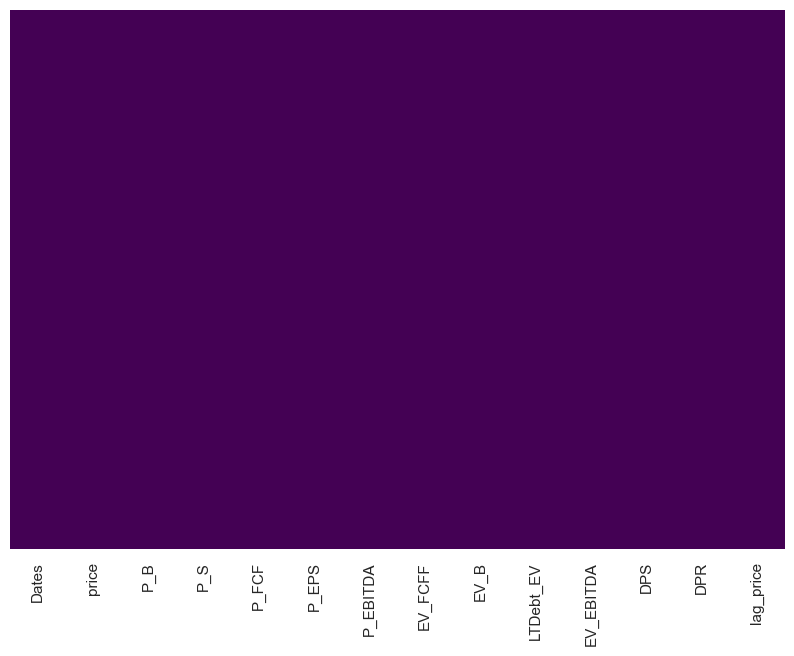

In [39]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [40]:
df.nunique()

Dates        2870
price        2633
P_B          2684
P_S          2605
P_FCF        2713
P_EPS        2713
P_EBITDA     2709
EV_FCFF      2729
EV_B         2697
LTDebt_EV    1925
EV_EBITDA    2725
DPS            10
DPR            35
lag_price    2632
dtype: int64

In [41]:
df.columns

Index(['Dates', 'price', 'P_B', 'P_S', 'P_FCF', 'P_EPS', 'P_EBITDA', 'EV_FCFF',
       'EV_B', 'LTDebt_EV', 'EV_EBITDA', 'DPS', 'DPR', 'lag_price'],
      dtype='object')

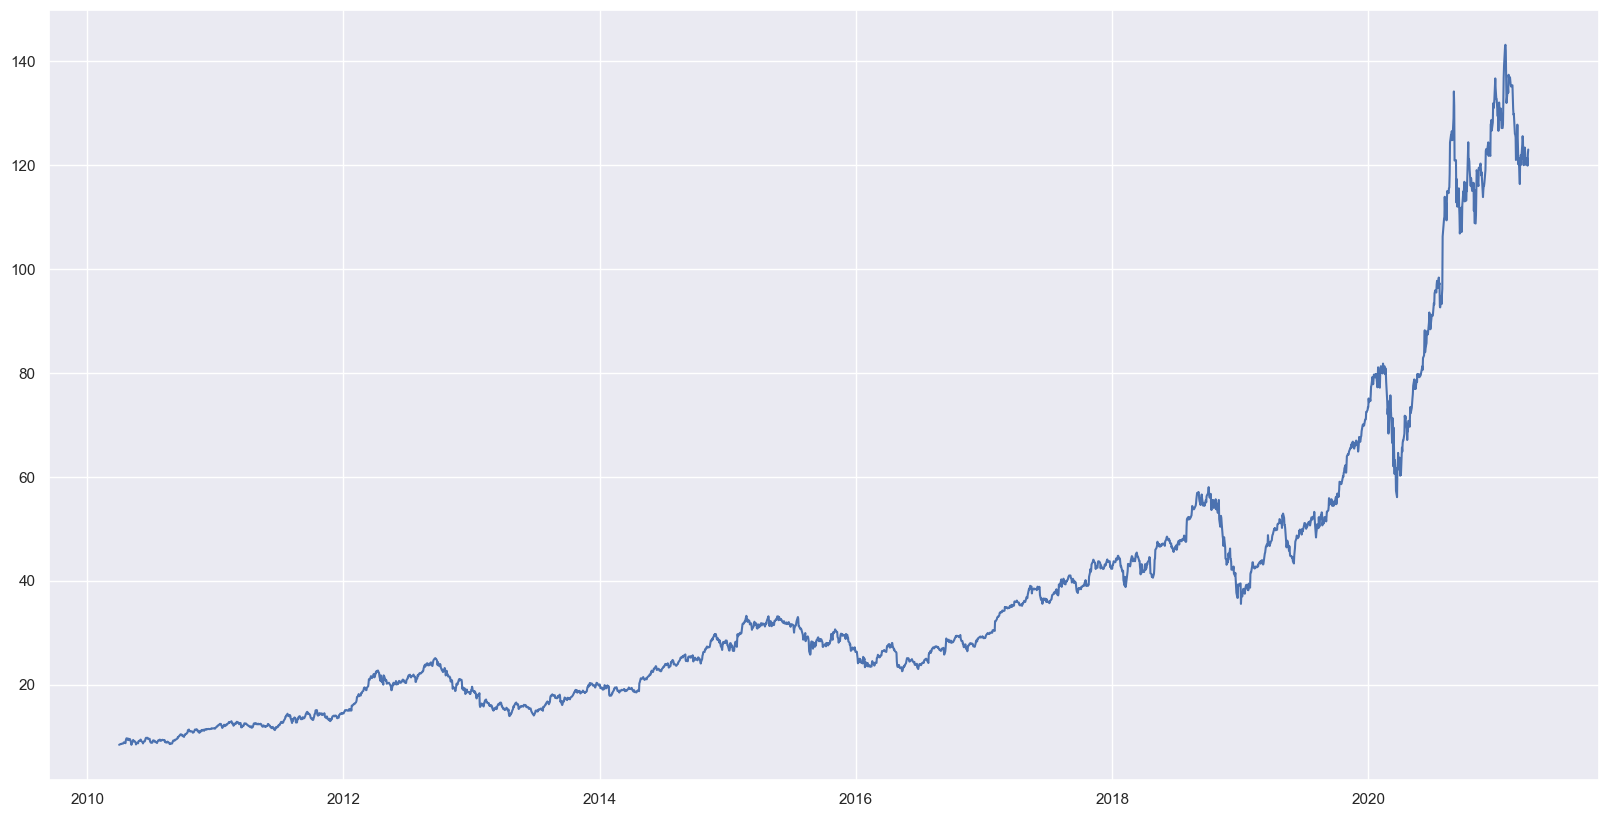

In [42]:
plt.figure(figsize=(20,10))
plt.plot(df.Dates, df.price)
plt.show()

In [43]:
P_lines = ['P_B', 'P_S', 'P_FCF', 'P_EPS', 'P_EBITDA']
EV_lines= ['EV_FCFF','EV_B', 'LTDebt_EV', 'EV_EBITDA']

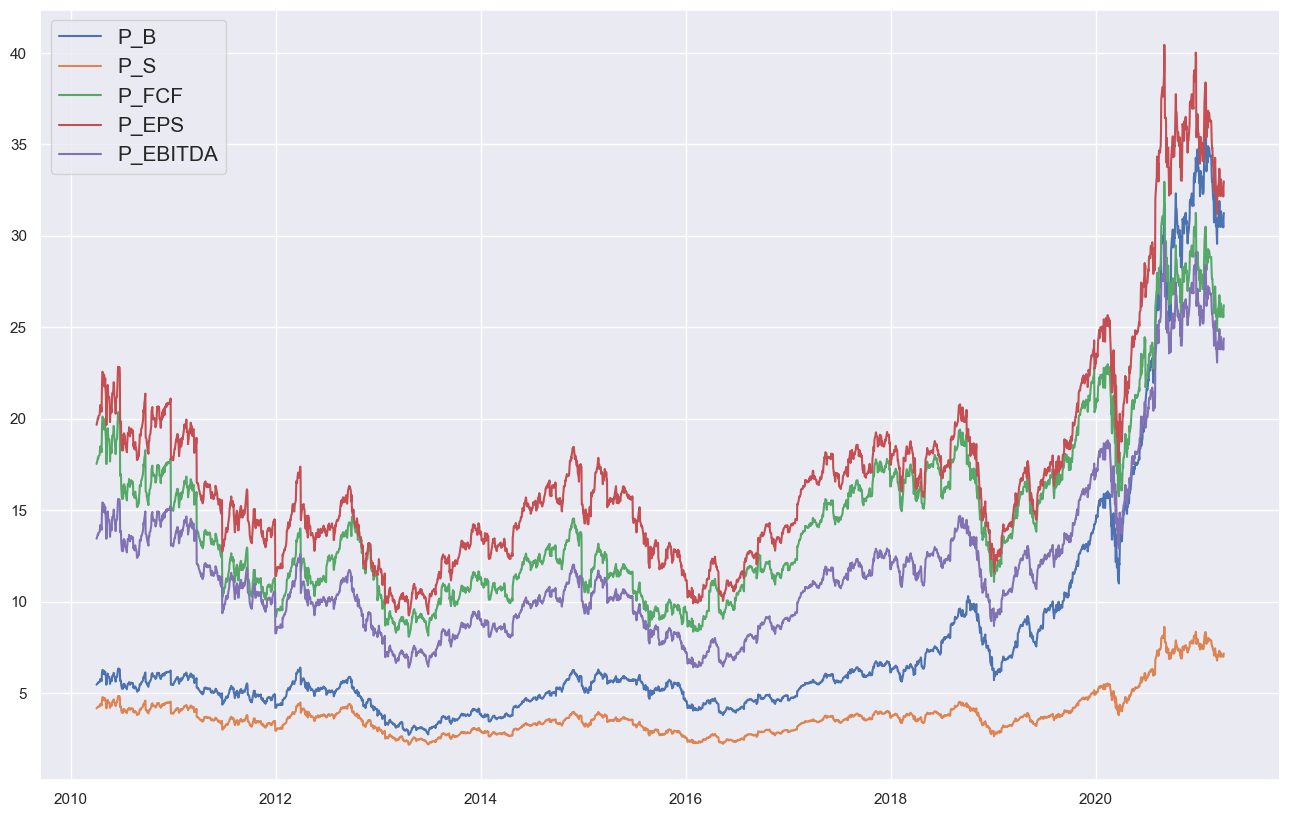

In [44]:
plt.figure(figsize=(16,10))

plt.plot(df.Dates, df[P_lines])
plt.legend(P_lines,loc='upper left',prop={'size': 15})
plt.show()

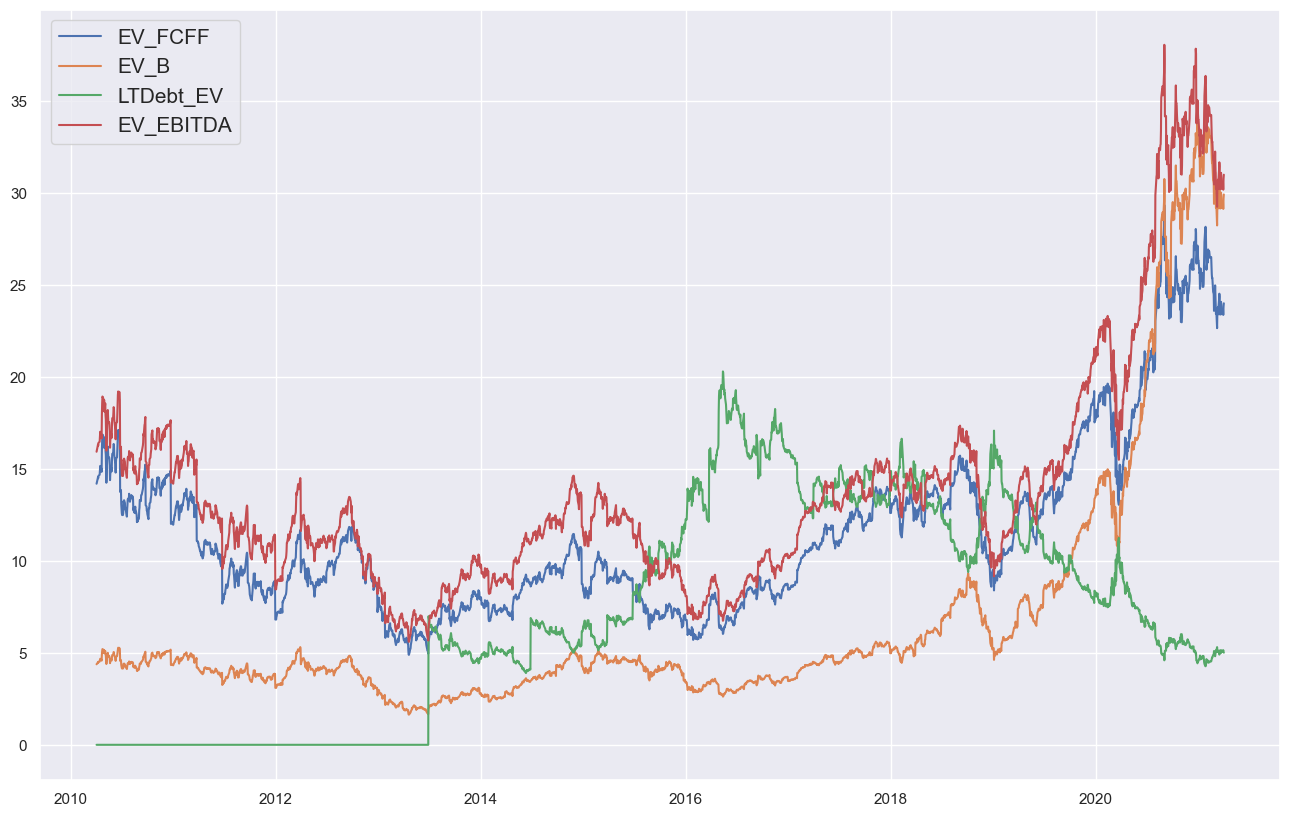

In [45]:
plt.figure(figsize=(16,10))

plt.plot(df.Dates, df[EV_lines])
plt.legend(EV_lines,loc='upper left',prop={'size': 15})
plt.show()
    

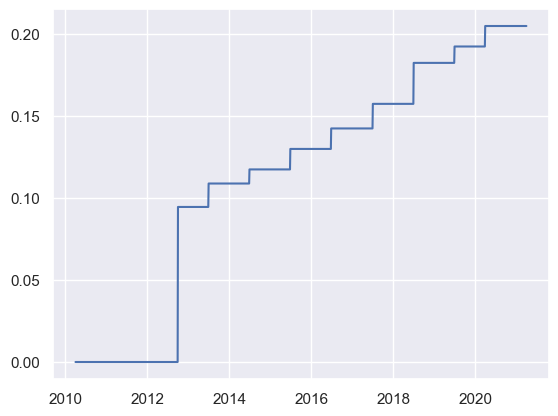

In [46]:
plt.plot(df['Dates'],df['DPS'])
plt.show()

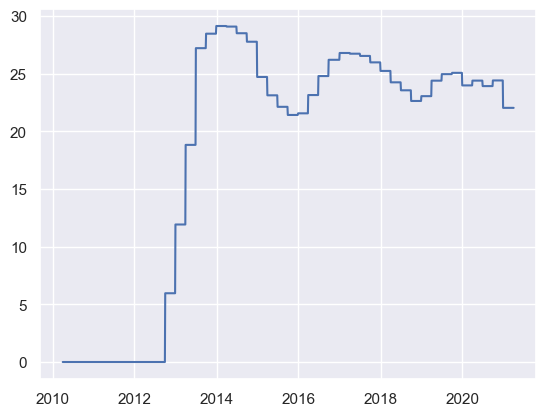

In [47]:
plt.plot(df['Dates'],df['DPR'])
plt.show()

In [48]:
# based on the charts above we should drop 'DPS', 'DPR', 'LTDebt_EV' or we should truncate the data.
df.drop(['DPS', 'DPR', 'LTDebt_EV'],axis=1, inplace=True)

---

### Creat moving Average Data Set

In [49]:
Moving_average = 62
df['MA_price'] = df['price'].rolling(window=Moving_average).mean()

In [50]:
df.head(65)

,Dates,price,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,EV_EBITDA,lag_price,MA_price
1,2010-04-02,8.428,5.4551,4.1605,17.5258,19.6642,13.4379,14.1951,4.3782,15.9334,8.428,NaN
2,2010-04-05,8.518,5.5133,4.2050,17.7129,19.8742,13.5814,14.3834,4.4362,16.1448,8.428,NaN
3,2010-04-06,8.555,5.5376,4.2235,17.7909,19.9617,13.6412,14.4619,4.4604,16.2329,8.518,NaN
4,2010-04-07,8.593,5.5621,4.2422,17.8696,20.0500,13.7015,14.5411,4.4849,16.3218,8.555,NaN
5,2010-04-08,8.570,5.5471,4.2307,17.8214,19.9958,13.6645,14.4925,4.4699,16.2672,8.593,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
61,2010-06-25,9.525,5.6511,4.2309,16.8687,19.7263,13.7813,13.7478,4.5659,16.0858,9.607,NaN
62,2010-06-28,9.582,5.6850,4.2563,16.9699,19.8447,13.8640,13.8495,4.5997,16.2047,9.525,9.100113
63,2010-06-29,9.149,5.4280,4.0639,16.2027,18.9475,13.2372,13.0786,4.3437,15.3028,9.582,9.111742
64,2010-06-30,8.983,5.3297,3.9903,15.9092,18.6043,12.9975,12.7838,4.2457,14.9577,9.149,9.119242


In [52]:
df.dropna(inplace=True)

In [53]:
df.head()

,Dates,price,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,EV_EBITDA,lag_price,MA_price
62,2010-06-28,9.582,5.6850,4.2563,16.9699,19.8447,13.8640,13.8495,4.5997,16.2047,9.525,9.100113
63,2010-06-29,9.149,5.4280,4.0639,16.2027,18.9475,13.2372,13.0786,4.3437,15.3028,9.582,9.111742
64,2010-06-30,8.983,5.3297,3.9903,15.9092,18.6043,12.9975,12.7838,4.2457,14.9577,9.149,9.119242
65,2010-07-01,8.874,5.2651,3.9419,15.7163,18.3787,12.8399,12.5899,4.1814,14.7309,8.983,9.124387
66,2010-07-02,8.819,5.2324,3.9175,15.6189,18.2648,12.7603,12.4921,4.1489,14.6164,8.874,9.128032


Now lets create our target variable that we can use to determine how informative the features are in determing whether or not the security is a buy or sell. Notice that we are not engineering any new variables. This is because we want to use metrics and terms that any finance professional would be familiar with.

---

In [54]:
# if last price > MA buy, otherwise sell. 
df['signal']= np.where(df['lag_price']>df['MA_price'],1,0)

In [55]:
df.head()

,Dates,price,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,EV_EBITDA,lag_price,MA_price,signal
62,2010-06-28,9.582,5.6850,4.2563,16.9699,19.8447,13.8640,13.8495,4.5997,16.2047,9.525,9.100113,1
63,2010-06-29,9.149,5.4280,4.0639,16.2027,18.9475,13.2372,13.0786,4.3437,15.3028,9.582,9.111742,1
64,2010-06-30,8.983,5.3297,3.9903,15.9092,18.6043,12.9975,12.7838,4.2457,14.9577,9.149,9.119242,1
65,2010-07-01,8.874,5.2651,3.9419,15.7163,18.3787,12.8399,12.5899,4.1814,14.7309,8.983,9.124387,0
66,2010-07-02,8.819,5.2324,3.9175,15.6189,18.2648,12.7603,12.4921,4.1489,14.6164,8.874,9.128032,0


In [56]:
df.dropna(inplace=True)

In [57]:
pd.crosstab(df['signal'], df['signal'], normalize='all')*100

signal,0,1
signal,,
0,32.53827,0.00000
1,0.00000,67.46173


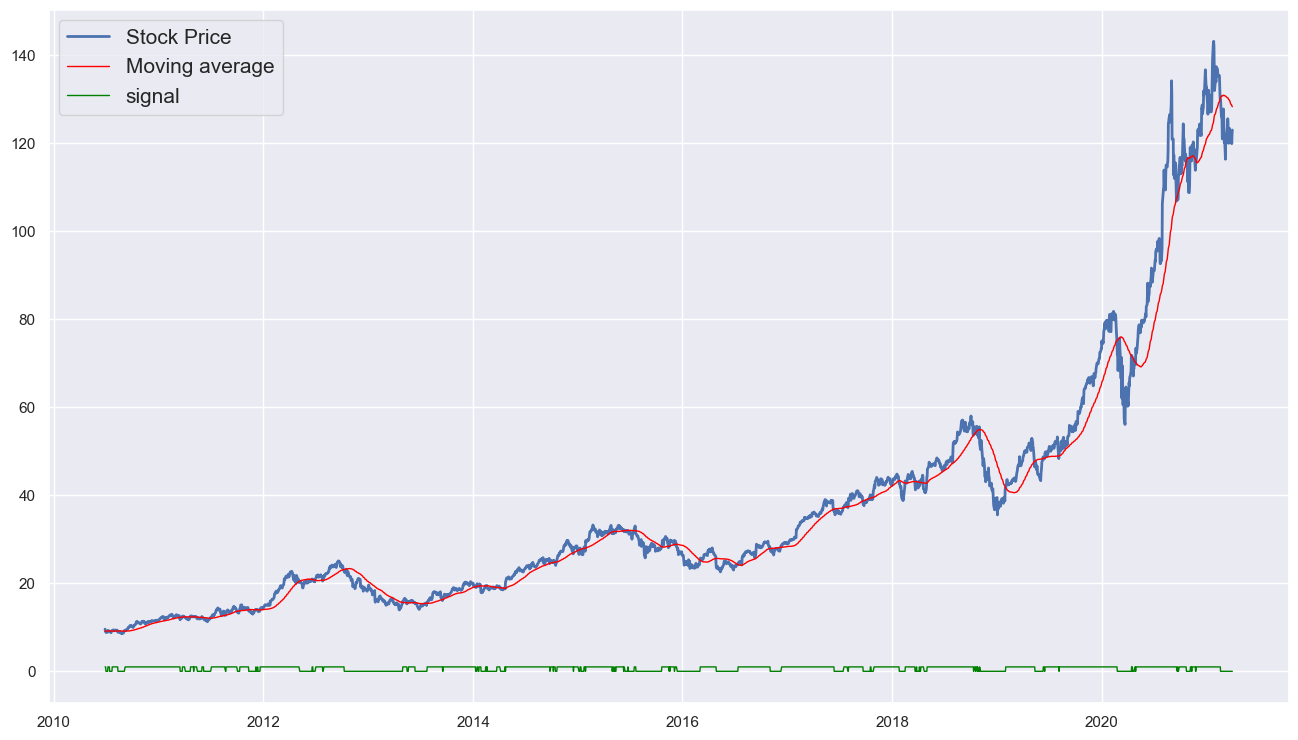

In [56]:
plt.figure(figsize=(16,9))
plt.plot( 'Dates', 'price', data=df, markerfacecolor='blue', markersize=12, linewidth=2, label='Stock Price')
plt.plot( 'Dates', 'MA_price', data=df, marker='', color='red', linewidth=1, label='Moving average')
plt.plot( 'Dates', 'signal', data=df, marker='', color='green', linewidth=1, label='signal')
plt.legend(loc='upper left',prop={'size': 15})

plt.show()

---

### Random Forest Classification

First, we need to remove some of the variables

In [58]:
df.columns

Index(['Dates', 'price', 'P_B', 'P_S', 'P_FCF', 'P_EPS', 'P_EBITDA', 'EV_FCFF',
       'EV_B', 'EV_EBITDA', 'lag_price', 'MA_price', 'signal'],
      dtype='object')

### Splitting the Data Set

In [59]:
y = df['signal']
X = df[['P_B', 'P_S', 'P_FCF', 'P_EPS', 'P_EBITDA', 'EV_FCFF','EV_B', 'EV_EBITDA', 'lag_price',]] # becareful inplace= False

split = int(0.70 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
###
X_train.tail()

,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,EV_EBITDA,lag_price
2023,6.2437,3.7171,16.5898,17.7925,11.9828,12.8822,5.0899,14.1237,42.308
2024,6.2426,3.7165,16.5869,17.7894,11.9807,12.8795,5.0888,14.1207,43.065
2025,6.2716,3.7338,16.6640,17.8721,12.0364,12.9529,5.1178,14.2012,43.058
2026,6.3430,3.7763,16.8537,18.0755,12.1734,13.1338,5.1893,14.3996,43.258
2027,6.3195,3.7622,16.7911,18.0084,12.1282,13.0742,5.1657,14.3341,43.750


In [60]:
X_test.head()

,P_B,P_S,P_FCF,P_EPS,P_EBITDA,EV_FCFF,EV_B,EV_EBITDA,lag_price
2028,6.3188,3.7618,16.7892,18.0063,12.1268,13.0723,5.1650,14.3321,43.588
2029,6.3173,3.7609,16.7853,18.0022,12.1240,13.0686,5.1636,14.3281,43.583
2030,6.3532,3.7823,16.8807,18.1045,12.1929,13.1596,5.1995,14.4278,43.573
2031,6.4188,3.8214,17.0550,18.2914,12.3188,13.3258,5.2652,14.6100,43.820
2032,6.4188,3.8214,17.0550,18.2914,12.3188,13.3258,5.2652,14.6100,44.273


In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
# Fitting RF classifier to the Training set

RF_classifier = RandomForestClassifier(bootstrap='False')
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap='False')

In [63]:
# Predicting the Test set results
y_hat = RF_classifier.predict(X_test)


---

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
print(confusion_matrix(y_test, y_hat))

[[ 53 166]
 [ 48 576]]


In [66]:
# defining our own confusion matrix function
from sklearn.metrics import confusion_matrix , accuracy_score, recall_score, precision_score, f1_score
def my_confusion_matrix(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    error_rate = round(1-accuracy,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])
    
    print("-----------------------------------------")
    print('Accuracy    = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision   = {}'.format(precision))
    print('Recall      = {}'.format(recall))
    print('f1_score    = {}'.format(f1score))
    print("-----------------------------------------")
    return cm_labled

In [67]:
my_confusion_matrix(y_test,y_hat)


-----------------------------------------
Accuracy    = 0.7461
Error_rate  = 0.2539
Precision   = 0.78
Recall      = 0.92
f1_score    = 0.84
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,53,166
Actual : positive,48,576


---

### Cross Validation

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [69]:
y_train.size

1966

In [72]:
1966/250

7.864

In [74]:
# correct way of time series cross validation using rolling windows forward walk

tscv = cross_val_score(estimator = RF_classifier, X = X_train, y = y_train, cv = TimeSeriesSplit(n_splits=8, max_train_size=250, gap=1 , test_size=60) , scoring="accuracy" )
tscv

array([0.36666667, 0.9       , 0.85      , 0.9       , 1.        ,
       0.6       , 0.7       , 0.96666667])

In [75]:
round(tscv.mean(),3)

0.785

In [76]:
round(tscv.std(),3)

0.202

### GridSearch

In [77]:
param_gridst = {'max_depth': [10,20,50], 'criterion': ['entropy','gini'], 'max_features':['log2','sqrt']} 

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
grid = GridSearchCV(RandomForestClassifier(n_estimators=100, random_state=100, bootstrap='False'),param_gridst,refit=True,verbose=2, cv=3)

In [80]:
# About 10 seconds
%time grid.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .criterion=entropy, max_depth=10, max_features=log2; total time=   0.3s
[CV] END .criterion=entropy, max_depth=10, max_features=log2; total time=   0.2s
[CV] END .criterion=entropy, max_depth=10, max_features=log2; total time=   0.2s
[CV] END .criterion=entropy, max_depth=10, max_features=sqrt; total time=   0.2s
[CV] END .criterion=entropy, max_depth=10, max_features=sqrt; total time=   0.2s
[CV] END .criterion=entropy, max_depth=10, max_features=sqrt; total time=   0.2s
[CV] END .criterion=entropy, max_depth=20, max_features=log2; total time=   0.2s
[CV] END .criterion=entropy, max_depth=20, max_features=log2; total time=   0.2s
[CV] END .criterion=entropy, max_depth=20, max_features=log2; total time=   0.2s
[CV] END .criterion=entropy, max_depth=20, max_features=sqrt; total time=   0.2s
[CV] END .criterion=entropy, max_depth=20, max_features=sqrt; total time=   0.2s
[CV] END .criterion=entropy, max_depth=20, max_f

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap='False',
                                              random_state=100),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 20, 50],
                         'max_features': ['log2', 'sqrt']},
             verbose=2)

In [81]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2'}

In [82]:
grid.best_estimator_

RandomForestClassifier(bootstrap='False', criterion='entropy', max_depth=20,
                       max_features='log2', random_state=100)

In [83]:
y_hat_opt = grid.predict(X_test)

In [84]:
my_confusion_matrix(y_test,y_hat_opt)

-----------------------------------------
Accuracy    = 0.7639
Error_rate  = 0.2361
Precision   = 0.77
Recall      = 0.98
f1_score    = 0.86
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,31,188
Actual : positive,11,613


---

### Feature Importance

In [85]:
features = list(X_train.columns)
features

['P_B',
 'P_S',
 'P_FCF',
 'P_EPS',
 'P_EBITDA',
 'EV_FCFF',
 'EV_B',
 'EV_EBITDA',
 'lag_price']

In [94]:
RF_classifier = RandomForestClassifier(n_estimators = 100,bootstrap='False', random_state= 1000)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap='False', random_state=1000)

In [95]:
importance = RF_classifier.feature_importances_
importance

array([0.07218533, 0.10660159, 0.15572516, 0.15262162, 0.10856988,
       0.10122455, 0.07153861, 0.06275723, 0.16877603])

In [96]:
FIM = pd.DataFrame({'Features': features , 'Feature_importance':importance})
FIM=FIM.sort_values(by=['Feature_importance'], ignore_index=True, ascending=False)
FIM

,Features,Feature_importance
0,lag_price,0.168776
1,P_FCF,0.155725
2,P_EPS,0.152622
3,P_EBITDA,0.108570
4,P_S,0.106602
5,EV_FCFF,0.101225
6,P_B,0.072185
7,EV_B,0.071539
8,EV_EBITDA,0.062757


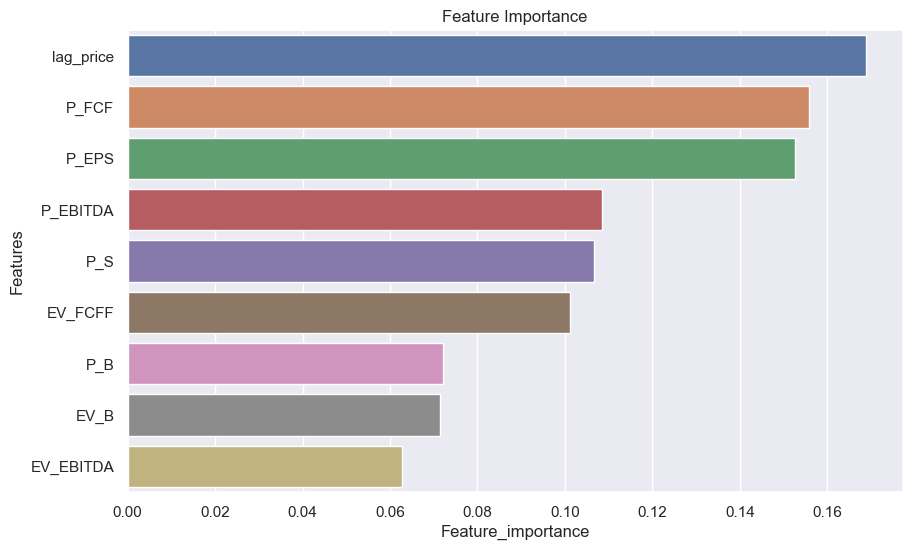

In [97]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(y='Features', x='Feature_importance', data=FIM)
plt.show()

---

Pick the winners and make stock price predictions!?

In [98]:
winners = FIM.head(4).tail(3)
winners

,Features,Feature_importance
1,P_FCF,0.155725
2,P_EPS,0.152622
3,P_EBITDA,0.108570


In [99]:
weights = winners.Feature_importance/winners.Feature_importance.sum()
weights

1    0.373516
2    0.366072
3    0.260411
Name: Feature_importance, dtype: float64

----
What are the latest available ratios as of Sep 2021? Using Nasdaq as the benchmark!? or any other comparables! 

In [102]:
# Apple 9/30/2021 (for today, you can use lower/upper bounds as well to get a ranch) https://www.macrotrends.net/stocks/charts/AAPL/apple/stock-price-history
EPS_aapl    = 5.61
FCF_aapl    = 5.51  #per share
EBITDA_aapl = 120.233/16.43 # EBITDA / outstanding shares

In [110]:
# MSFT average 9/30/2021 
P_FCF    = 36.35
P_EPS    = 33.30
P_EBITDA = 81.60 / 7.6

In [112]:
# industry (XLK) average 9/30/2021: https://ycharts.com/companies/XLK (you could use different companies to get a range for your predictions)
P_FCF    = 22.95
P_EPS    = 32.58
P_EBITDA = 19.7

In [113]:
Apple_price = (weights.iloc[0] * FCF_aapl * P_FCF)  +  (weights.iloc[1] * EPS_aapl * P_EPS)  + (weights.iloc[2] * EBITDA_aapl * P_EBITDA)
Apple_price

151.68280305834546

https://www.macrotrends.net/stocks/charts/AAPL/apple/stock-price-history

https://www.tradingview.com/chart/AAPL

https://ycharts.com/companies/AAPL

https://finbox.com/NASDAQGS:AAPL/compare/NYSE:HPQ,NASDAQGS:MSFT,NASDAQGS:GOOGL,NASDAQGS:AMZN,NASDAQGS:NFLX,NASDAQGS:HTHT